# IMDb Sentiment Classifier: BERT
This notebook builds a sentiment classifier using BERT on the IMDb Movie Review Dataset.
We’ll classify reviews as positive or negative using a pretrained transformer model `bert-base-uncased`

## Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
import os

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast as BertTokenizer
from transformers import BertForSequenceClassification, get_scheduler
from torch.optim import Adam, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

## Seeding

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

## Load and Split Data
We load the raw data without cleaning, as in the case of using BERT, we want the raw data unlike the classical ML models that needed the cleaned data.BERT handles raw text efficiently via tokenization.

We split the dataset into train 70%, validation 15%, and test 15%

In [7]:
# Loading the raw data
imdb_reviews_df = pd.read_csv("/content/IMDB Dataset.csv")
imdb_reviews_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:
# Encoding labels such that positive:1, and negative:0
imdb_reviews_df['label'] = imdb_reviews_df['sentiment'].map({'positive': 1, 'negative': 0})

reviews = imdb_reviews_df['review'].tolist()
labels = imdb_reviews_df['label'].tolist()

In [9]:
# Split into train set with 70% and temporary set with 30% to be further split to test and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(
    reviews, labels, test_size=0.3, stratify=labels, random_state=42
)

#Split temp into validation set with 15% and test set with 15%
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(f"Train set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")


Train set size: 35000
Validation set size: 7500
Test set size: 7500


## Tokenization Using BertTokenizer
We use the `bert-base-uncased` tokenizer, which:
- Lowercases all text (since it's uncased)
- Adds special tokens
- Pads or truncates sequences to a fixed maximum length
- Converts text into token IDs and attention masks for the BERT model

In [2]:
# Load the pretrained tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

We encode the train and test sets such that train_encodings and test_encodings contain:
- input_ids: token indices
- attention_mask: 1 where tokens exist, 0 for padding

In [11]:
# BERT supports up to 512, but we use 256 for speed and memory
MAX_LEN = 256

# Tokenizing the train set
train_encodings = tokenizer(
    X_train,
    truncation = True,
    padding = True,
    max_length = MAX_LEN,
    return_tensors = "pt"
)

# Tokenizing the val set
val_encodings = tokenizer(
    X_val,
    truncation=True,
    padding=True,
    max_length=MAX_LEN,
    return_tensors="pt"
)

# Tokenizing the test set
test_encodings = tokenizer(
    X_test,
    truncation = True,
    padding = True,
    max_length = MAX_LEN,
    return_tensors = "pt"
)

In [12]:
# Checking on the first example
i = 0

print("Original Review:")
print(X_train[i])
print("\nTokenized Input IDs:")
print(train_encodings['input_ids'][i])

print("\nAttention Mask:")
print(train_encodings['attention_mask'][i])

Original Review:
If you want to see a true thriller, rent this!!! It's not from the director or screenwriter of "Scream", doesn't feature overacting, overpaid "TV" actors passing off as "stars", and is not a run of the mill special effects bonanza. Instead you'll get a top-notch, edgy, very strong (in violence) yet thrilling nailbiter.

Tokenized Input IDs:
tensor([  101,  2065,  2017,  2215,  2000,  2156,  1037,  2995, 10874,  1010,
         9278,  2023,   999,   999,   999,  2009,  1005,  1055,  2025,  2013,
         1996,  2472,  2030, 11167,  1997,  1000,  6978,  1000,  1010,  2987,
         1005,  1056,  3444,  2058, 18908,  2075,  1010,  2058,  4502,  3593,
         1000,  2694,  1000,  5889,  4458,  2125,  2004,  1000,  3340,  1000,
         1010,  1998,  2003,  2025,  1037,  2448,  1997,  1996,  4971,  2569,
         3896, 14753, 16076,  1012,  2612,  2017,  1005,  2222,  2131,  1037,
         2327,  1011, 18624,  1010,  3968,  6292,  1010,  2200,  2844,  1006,
         1999,  

In [13]:
# Convert labels to torch tensors
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)
test_labels = torch.tensor(y_test)

In [14]:
# Seeing how they look
train_labels

tensor([1, 1, 1,  ..., 0, 0, 0])

## Creating a PyTorch Dataset Class
To use our tokenized data with PyTorch, we wrap it in a custom Dataset class, which returns inputs and labels for each sample.

In [15]:
class IMDbDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        item = {key: val[index] for key, val in self.encodings.items()}
        item['labels'] = self.labels[index]
        return item

### Creating Dataset Instances for each train, val and test sets

In [16]:
train_dataset = IMDbDataset(train_encodings, train_labels)
val_dataset = IMDbDataset(val_encodings, val_labels)
test_dataset = IMDbDataset(test_encodings, test_labels)

### Creating DataLoaders
- DataLoaders handle batching, shuffling, and parallel loading of data.
- They allow the model to efficiently process batches during training and evaluation.

In [17]:
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [18]:
print(f"\nBatch size: {BATCH_SIZE}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")


Batch size: 16
Number of training batches: 2188
Number of validation batches: 469
Number of test batches: 469


## Load Pretrained BERT for Sequence Classification & Setting Parameters

In [ ]:
NUM_LABELS = 2

# Load pretrained BERT model with a classification head for 2 classes (positive/negative)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=NUM_LABELS)

In [20]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

print("Using device:", device)

Using device: cuda


In [21]:
EPOCHS = 3
LEARNING_RATE = 2e-5
WARMUP_STEPS = 500

# Using AdamW Optimizer
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

# Calculate total training steps
total_steps = len(train_loader) * EPOCHS

# Create learning rate scheduler
scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=total_steps
)

In [22]:
# Summary for the Training Parameters
print(f"\nTraining parameters:")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Epochs: {EPOCHS}")
print(f"Warmup steps: {WARMUP_STEPS}")
print(f"Total training steps: {total_steps}")


Training parameters:
Learning rate: 2e-05
Epochs: 3
Warmup steps: 500
Total training steps: 6564


## Training and Evaluating Functions

In [23]:
# Function to get accuracy
def get_accuracy(preds, labels):
    # Get the predicted class by getting the index of the highest score
    pred_labels = torch.argmax(preds, dim=1)
    # calculates the total number of correct predictions comparing with the labels
    correct = (pred_labels == labels).sum().item()
    # Calculates the accuracy of correct predictions over total
    return correct / len(labels)

In [24]:
# Training one epoch
def train_epoch(model, dataloader, optimizer, scheduler):
    # Training mode for the model
    model.train()

    # Initializing to accumulate the training loss and accuracy over the epoch
    total_loss = 0
    total_acc = 0

    # Looping through each batch of data of input-output pairs
    for batch_idx, batch in enumerate(dataloader):
        # Clears previous gradients
        optimizer.zero_grad()

        # To make sure they are on the device we are training on
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass which computes predictions and loss
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        # Getting accuracy for current batch
        acc = get_accuracy(logits, labels)

        # Backpropagation
        loss.backward()
        # Update weights and optimizing
        optimizer.step()
        scheduler.step()

        # Accumulate loss and accuracy
        total_loss += loss.item()
        total_acc += acc

        # Print progress every 500 batches
        if batch_idx % 500 == 0:
            print(f"Batch {batch_idx}/{len(dataloader)}, Loss: {loss.item():.4f}, Acc: {acc:.4f}")

    # Returning the epoch loss and accuracy over all batches
    avg_loss = total_loss / len(dataloader)
    avg_acc = total_acc / len(dataloader)
    return avg_loss, avg_acc

In [25]:
# Evaluate the model (for validation or testing)
def eval_model(model, dataloader):
    # Evaluating mode for the model
    model.eval()

    # Initializing to accumulate the training loss and accuracy over the epoch
    total_loss = 0
    total_acc = 0

    # No gradient calculation in evaluating, saving memory
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

            loss = outputs.loss
            logits = outputs.logits

            # Calculate accuracy per batch
            acc = get_accuracy(logits, labels)

            # Accumulate loss and accuracy
            total_loss += loss.item()
            total_acc += acc

    # Returning avg loss and accuracy
    avg_loss = total_loss / len(dataloader)
    avg_acc = total_acc / len(dataloader)
    return avg_loss, avg_acc


## Training the Model

In [27]:
# Store  metrics for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [28]:
# Loop over the number of epochs
start_time = time.time()

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")

    # Train for one epoch
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Evaluate on the validation set
    val_loss, val_acc = eval_model(model, val_loader)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc * 100:.2f}%")
    print(f"Val Loss:   {val_loss:.4f} | Val Accuracy:   {val_acc * 100:.2f}%")


end_time = time.time()
bert_training_time = end_time - start_time
print(f"\nTotal BERT Training Time: {bert_training_time:.2f} seconds")


Epoch 1/3
Batch 0/2188, Loss: 0.7002, Acc: 0.4375
Batch 500/2188, Loss: 0.1366, Acc: 0.9375
Batch 1000/2188, Loss: 0.2971, Acc: 0.7500
Batch 1500/2188, Loss: 0.4068, Acc: 0.8125
Batch 2000/2188, Loss: 0.1236, Acc: 0.9375
Train Loss: 0.2779 | Train Accuracy: 87.95%
Val Loss:   0.2164 | Val Accuracy:   91.57%

Epoch 2/3
Batch 0/2188, Loss: 0.0698, Acc: 1.0000
Batch 500/2188, Loss: 0.1877, Acc: 0.9375
Batch 1000/2188, Loss: 0.1372, Acc: 0.9375
Batch 1500/2188, Loss: 0.1130, Acc: 1.0000
Batch 2000/2188, Loss: 0.1481, Acc: 0.9375
Train Loss: 0.1354 | Train Accuracy: 95.16%
Val Loss:   0.2142 | Val Accuracy:   92.36%

Epoch 3/3
Batch 0/2188, Loss: 0.0119, Acc: 1.0000
Batch 500/2188, Loss: 0.1019, Acc: 0.9375
Batch 1000/2188, Loss: 0.0026, Acc: 1.0000
Batch 1500/2188, Loss: 0.0138, Acc: 1.0000
Batch 2000/2188, Loss: 0.0227, Acc: 1.0000
Train Loss: 0.0563 | Train Accuracy: 98.33%
Val Loss:   0.2519 | Val Accuracy:   92.61%

Total BERT Training Time: 4818.46 seconds


## Visualizing Performance

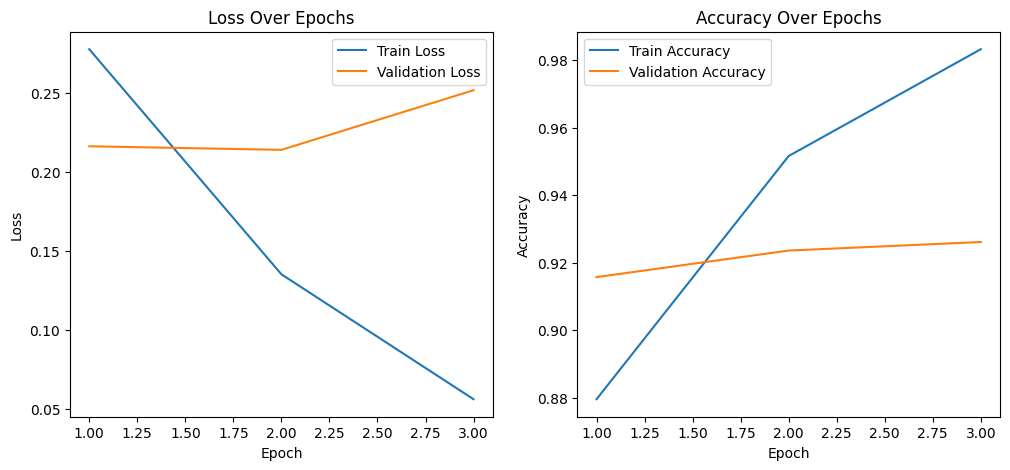

In [29]:
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.show()

## Saving the Model

In [30]:
save_directory = "./bert_imdb_model/"
os.makedirs(save_directory, exist_ok=True)

# Saving the model and tokenizer
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('./bert_imdb_model/tokenizer_config.json',
 './bert_imdb_model/special_tokens_map.json',
 './bert_imdb_model/vocab.txt',
 './bert_imdb_model/added_tokens.json',
 './bert_imdb_model/tokenizer.json')

## Loading the Model

In [31]:
loaded_model = BertForSequenceClassification.from_pretrained('./bert_imdb_model')
loaded_tokenizer = BertTokenizer.from_pretrained('./bert_imdb_model')
loaded_model.to(device)
loaded_model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Testing the Model

In [32]:
test_loss, test_acc = eval_model(loaded_model, test_loader)
print(f"\nTest Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc*100:.2f}%")


Test Results:
Test Loss: 0.2334
Test Accuracy: 93.08%


In [33]:
# Helper function to get all predictions and labels to make a "Confusion Matrix" and detailed evaluation
def get_predictions(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

In [34]:
# Get predictions and true labels on test set
test_preds, test_true = get_predictions(loaded_model, test_loader, device)

In [35]:
print("\nClassification Report:")
print(classification_report(test_true, test_preds, target_names=["Negative", "Positive"]))


Classification Report:
              precision    recall  f1-score   support

    Negative       0.94      0.93      0.93      3750
    Positive       0.93      0.94      0.93      3750

    accuracy                           0.93      7500
   macro avg       0.93      0.93      0.93      7500
weighted avg       0.93      0.93      0.93      7500



<Figure size 800x600 with 0 Axes>

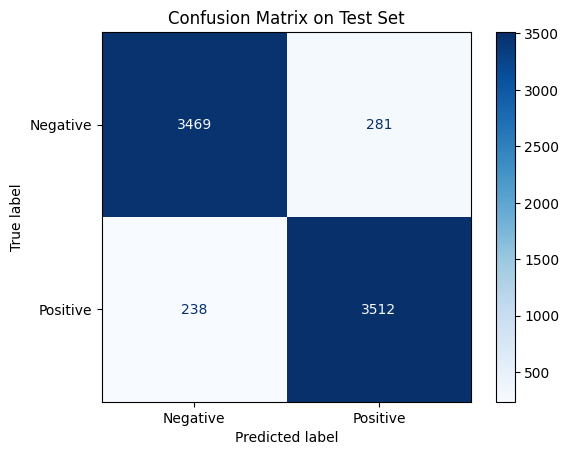

In [36]:
# Plot confusion matrix
cm = confusion_matrix(test_true, test_preds)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix on Test Set")
plt.show()

## Prediction Function

In [9]:
def predict_sentiment(text, model, tokenizer, device, max_len=256):
    model.eval()

    # Tokenize input
    inputs = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=max_len,
        return_tensors="pt"
    )

    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Getting the prediction
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        pred_prob = torch.softmax(logits, dim=1)
        pred_label = torch.argmax(pred_prob, dim=1).item()

    sentiment = "positive" if pred_label == 1 else "negative"
    confidence = pred_prob[0][pred_label].item()

    return {"sentiment": sentiment, "confidence": confidence}

In [38]:
test_reviews = [
    "This movie was absolutely amazing! The acting was superb and the plot was engaging.",
    "Terrible movie. Boring plot and bad acting. Complete waste of time.",
    "It was okay, nothing special but not bad either.",
    "One of the best films I've ever seen! Highly recommend!"
]

print("\nSample Predictions:")
print("=" * 60)
for i, review in enumerate(test_reviews):
    result = predict_sentiment(review, loaded_model, loaded_tokenizer, device)
    print(f"Review {i+1}: {review}")
    print(f"Prediction: {result['sentiment'].upper()} (confidence: {result['confidence']:.3f})")
    print("-" * 60)


Sample Predictions:
Review 1: This movie was absolutely amazing! The acting was superb and the plot was engaging.
Prediction: POSITIVE (confidence: 0.997)
------------------------------------------------------------
Review 2: Terrible movie. Boring plot and bad acting. Complete waste of time.
Prediction: NEGATIVE (confidence: 0.999)
------------------------------------------------------------
Review 3: It was okay, nothing special but not bad either.
Prediction: NEGATIVE (confidence: 0.603)
------------------------------------------------------------
Review 4: One of the best films I've ever seen! Highly recommend!
Prediction: POSITIVE (confidence: 0.997)
------------------------------------------------------------


## Summary

In [41]:
bert_results = {
    "Model": "BERT (bert-base-uncased) on IMDb Reviews",
    "Train Accuracy": f"{train_accuracies[-1]*100:.2f}%",
    "Test Accuracy": f"{test_acc*100:.2f}%",
    "Training Time (s)": round(bert_training_time, 2)
}


In [42]:
bert_results

{'Model': 'BERT (bert-base-uncased) on IMDb Reviews',
 'Train Accuracy': '98.33%',
 'Test Accuracy': '93.08%',
 'Training Time (s)': 4818.46}

## After Uploading Model to hugging face

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

print("Using device:", device)

Using device: cpu


In [7]:
model = BertForSequenceClassification.from_pretrained("tarneemalaa/bert_imdb_model")
tokenizer = BertTokenizer.from_pretrained("tarneemalaa/bert_imdb_model")

In [10]:
test_reviews = [
    "This movie was absolutely amazing! The acting was superb and the plot was engaging.",
    "Terrible movie. Boring plot and bad acting. Complete waste of time.",
    "It was okay, nothing special but not bad either.",
    "One of the best films I've ever seen! Highly recommend!"
]

print("\nSample Predictions:")
print("=" * 60)
for i, review in enumerate(test_reviews):
    result = predict_sentiment(review, model, tokenizer, device)
    print(f"Review {i+1}: {review}")
    print(f"Prediction: {result['sentiment'].upper()} (confidence: {result['confidence']:.3f})")
    print("-" * 60)


Sample Predictions:
Review 1: This movie was absolutely amazing! The acting was superb and the plot was engaging.
Prediction: POSITIVE (confidence: 0.997)
------------------------------------------------------------
Review 2: Terrible movie. Boring plot and bad acting. Complete waste of time.
Prediction: NEGATIVE (confidence: 0.999)
------------------------------------------------------------
Review 3: It was okay, nothing special but not bad either.
Prediction: NEGATIVE (confidence: 0.603)
------------------------------------------------------------
Review 4: One of the best films I've ever seen! Highly recommend!
Prediction: POSITIVE (confidence: 0.997)
------------------------------------------------------------
